Table of contents
<!-- # Table of Contents
- [Load and Process Data](#Load-and-Process-Data)
- [Creating the Network](#Creating-the-Network)
- [Louvain Communities](#Louvain-Communities)
- [Analyse the Genres with the Communities](#Analyse-the-Genres-with-the-Communities)
- [Detailed Community Summaries](#Detailed-Community-Summaries)
- [Analyse Sentiments within Communities](#Analyse-Sentiments-within-Communities)
- [Analyse Rating within Communities](#Analyse-Rating-within-Communities)
- [Movie Lengths - Not Used](#Movie-Lengths---Not-Used)
- [Betweenness Centrality - Not Used](#Betweenness-Centrality---Not-Used)
- [Sentiment Density for the Genres in a KDE](#Sentiment-Density-for-the-Genres-in-a-KDE) -->



# Imports

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
from itertools import combinations

import networkx as nx
from itertools import combinations
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt
import random

from collections import Counter
import pandas as pd

import pandas as pd
import glob

from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
import numpy as np
from scipy.spatial import ConvexHull

import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

import re


# Load and process data

- Combine all data into one merged dataframe.

- Loading, merging, and transforming the datasets to create a dataset of movies, including their genres, ratings, reviews, sentiment scores, and associated tags. 

- Nested structures for ratings, reviews, and tags grouped by movie.

- The result is a detailed, merged dataset (merged_df) combining everything for further analysis.


**Processing includes:**
- Rows with missing average_sentiment values are excluded.
- Ratings, reviews, and scores are filtered to only include movieId values present in the nested_df.
- Movie titles are split to extract the release year, and the year is stored in a separate column.


In [3]:
movie_sentiment = pd.read_csv('../movie_sentiment_scores.csv')
rating_vs_sentiment = pd.read_csv('../movie_ratings_vs_sentiments.csv')
reviews = pd.read_csv('../sampled_reviews.csv')

# Grouplens data
scores = pd.read_csv('../grouplens_data/ml-latest/genome-scores.csv')
tags = pd.read_csv('../grouplens_data/ml-latest/genome-tags.csv')
links = pd.read_csv('../grouplens_data/ml-latest/links.csv')
movies = pd.read_csv('../grouplens_data/ml-latest/movies.csv')
ratings = pd.read_csv('../grouplens_data/ml-latest/ratings.csv')

# IMBd data
path = "../dataset/1_movies_per_genre/"  
all_files = glob.glob(path + "*.csv")
list_dataframes = []

for filename in all_files:
    df = pd.read_csv(filename)
    list_dataframes.append(df)

# All movies in one dataframe
movies_df = pd.concat(list_dataframes, ignore_index=True)

# Nested dataframe for everything
nested_df = pd.merge(movies, movie_sentiment, on="movieId", how="left")
nested_df = pd.merge(nested_df, rating_vs_sentiment, on="movieId", how="left", suffixes=("", "_rating"))
nested_df = pd.merge(nested_df, links, on="movieId", how="left")

nested_df = nested_df[nested_df['average_sentiment'].notna()]

ratings = ratings[ratings['movieId'].isin(nested_df['movieId'])]
reviews = reviews[reviews['movieId'].isin(nested_df['movieId'])]
scores = scores[scores['movieId'].isin(nested_df['movieId'])]
ratings_nested = ratings.groupby('movieId').apply(lambda x: x[['userId', 'rating', 'timestamp']].to_dict(orient='records')).reset_index(name='ratings')
reviews_nested = reviews.groupby('movieId').apply(lambda x: x[['review']].to_dict(orient='records')).reset_index(name='reviews')
tags_nested = scores.merge(tags, on='tagId').groupby('movieId').apply(lambda x: x[['tag', 'relevance']].to_dict(orient='records')).reset_index(name='tags')

nested_df = pd.merge(nested_df, ratings_nested, on="movieId", how="left")
nested_df = pd.merge(nested_df, reviews_nested, on="movieId", how="left")
nested_df = pd.merge(nested_df, tags_nested, on="movieId", how="left")
nested_df = nested_df[['movieId', 'title', 'genres', 'average_sentiment', 'ratings', 'reviews', 'tags','average_rating']]

nested_df['year'] = nested_df['title'].str.extract(r'\((\d{4})\)').astype(int)
nested_df['title'] = nested_df['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Final merged dataframe
merged_df = pd.merge(movies_df, nested_df, left_on="name", right_on="title", how="inner")


/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_5220/1432388656.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratings_nested = ratings.groupby('movieId').apply(lambda x: x[['userId', 'rating', 'timestamp']].to_dict(orient='records')).reset_index(name='ratings')
/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_5220/1432388656.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  re

# Creating the network

The graph:
- Nodes: Represent movies (movieId).
- Edges: Exist between two nodes (movies) if they share a certain threshold of common tags (in this case, 5 or more tags).
- Edge Weights: The weight of each edge corresponds to the number of shared tags between the connected movies.


Compute the number of nodes and edges and plot the degree distribution.

In [4]:
num_sorted = 50
num_shared = 7

movie_top_tags = {}
for _, row in merged_df.iterrows():
    movie_id = row['movieId']
    tags = row['tags']
    
    if isinstance(tags, list) and all(isinstance(tag, dict) for tag in tags):
        sorted_tags = sorted(tags, key=lambda x: x['relevance'], reverse=True)
        movie_top_tags[movie_id] = [tag['tag'] for tag in sorted_tags[:num_sorted]]
    else:
        movie_top_tags[movie_id] = []

movie_ids = merged_df['movieId'].unique()

G_tags = nx.Graph()

for movie1, movie2 in tqdm.tqdm(combinations(movie_ids, 2)):
    tags1 = movie_top_tags.get(movie1, [])
    tags2 = movie_top_tags.get(movie2, [])
    shared_tags = set(tags1) & set(tags2)
    if len(shared_tags) >= num_shared:
        G_tags.add_edge(movie1, movie2, weight=len(shared_tags))

print("Numer of nodes: ", len(G_tags.nodes))
print("Numer of edges: ", len(G_tags.edges))

391170it [00:03, 125131.35it/s]

Numer of nodes:  831
Numer of edges:  196554


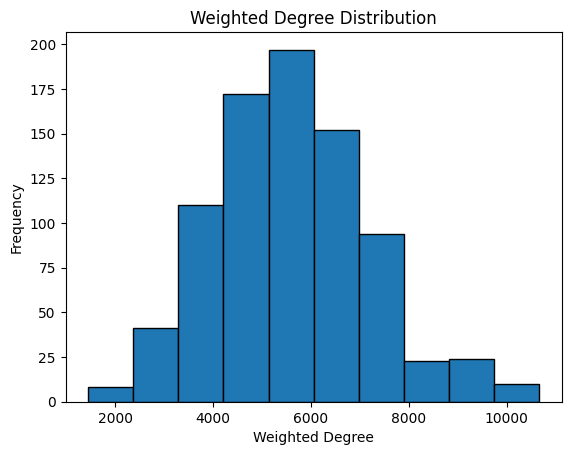

In [5]:
weighted_degrees = [sum(data['weight'] for _, _, data in G_tags.edges(node, data=True)) for node in G_tags.nodes()]

plt.hist(weighted_degrees, bins=10, edgecolor='k')
plt.xlabel("Weighted Degree")
plt.ylabel("Frequency")
plt.title("Weighted Degree Distribution")
plt.show()


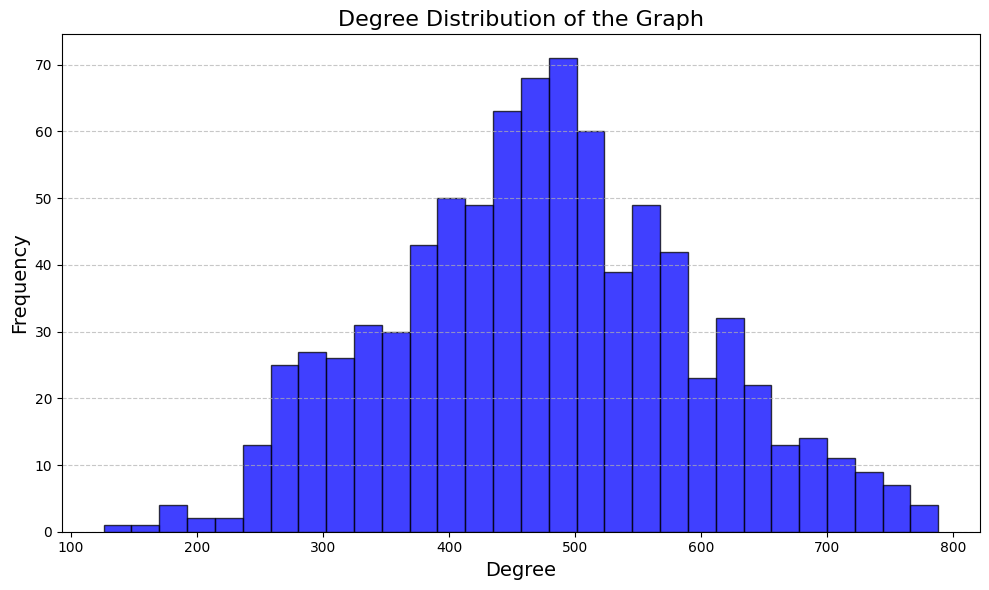

In [6]:
degrees = dict(G_tags.degree())

sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
degrees = dict(G_tags.degree())
degree_values = list(degrees.values())

plt.figure(figsize=(10, 6))
plt.hist(degree_values, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title('Degree Distribution of the Graph', fontsize=16)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Louvain Communities
- Detecting Louvain communities
- Creating a visualization of the communities, using sentiment scores for node coloring.
- Highlighting community boundaries using convex hulls and position nodes in a way that clusters communities visually.
- Creating a summary dataframe for the communities

Plotting the number of nodes in each community.

Generating visual representation of the top tags in each community and the community distribution for each genre.

Number of communities detected: 3


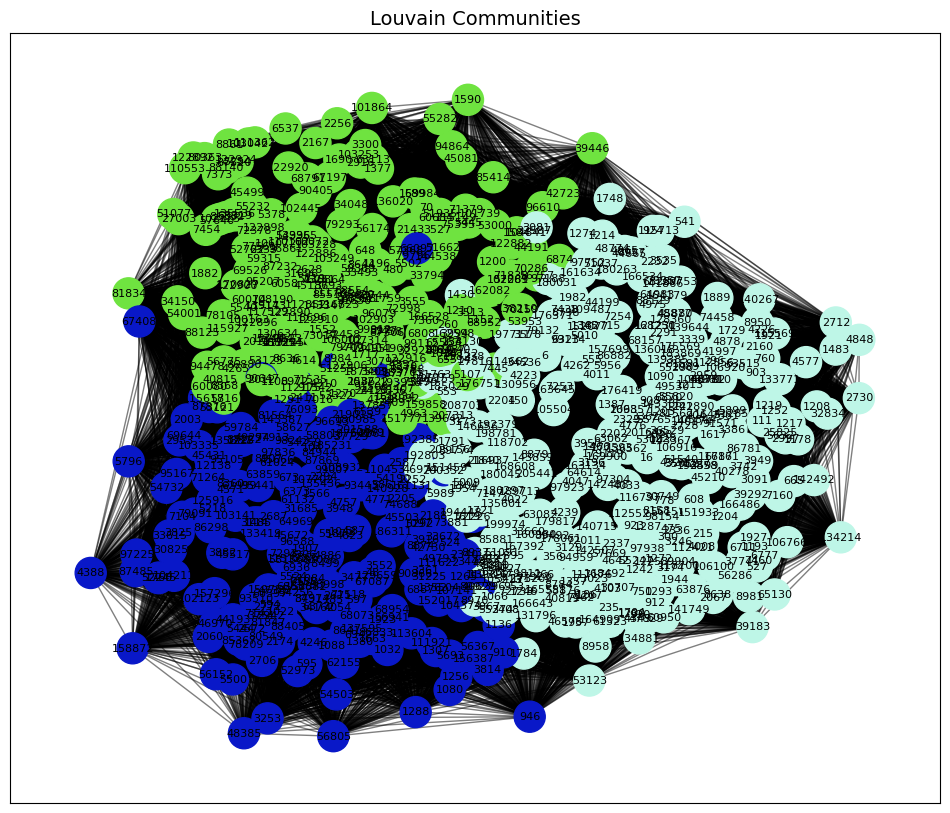

In [7]:

communities = louvain_communities(G_tags, weight="weight")
print(f"Number of communities detected: {len(communities)}")

color_map = {}
for idx, community in enumerate(communities):
    color = f"#{random.randint(0, 0xFFFFFF):06x}"  
    for node in community:
        color_map[node] = color

node_colors = [color_map[node] for node in G_tags.nodes()]

plt.figure(figsize=(12, 10))

pos = nx.spring_layout(G_tags)  
nx.draw_networkx_nodes(G_tags, pos,node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G_tags,pos, alpha=0.5)
nx.draw_networkx_labels(G_tags, pos,font_size=8, font_color="black")

plt.title("Louvain Communities", fontsize=14)
plt.show()

/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_5220/1449735500.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=10)


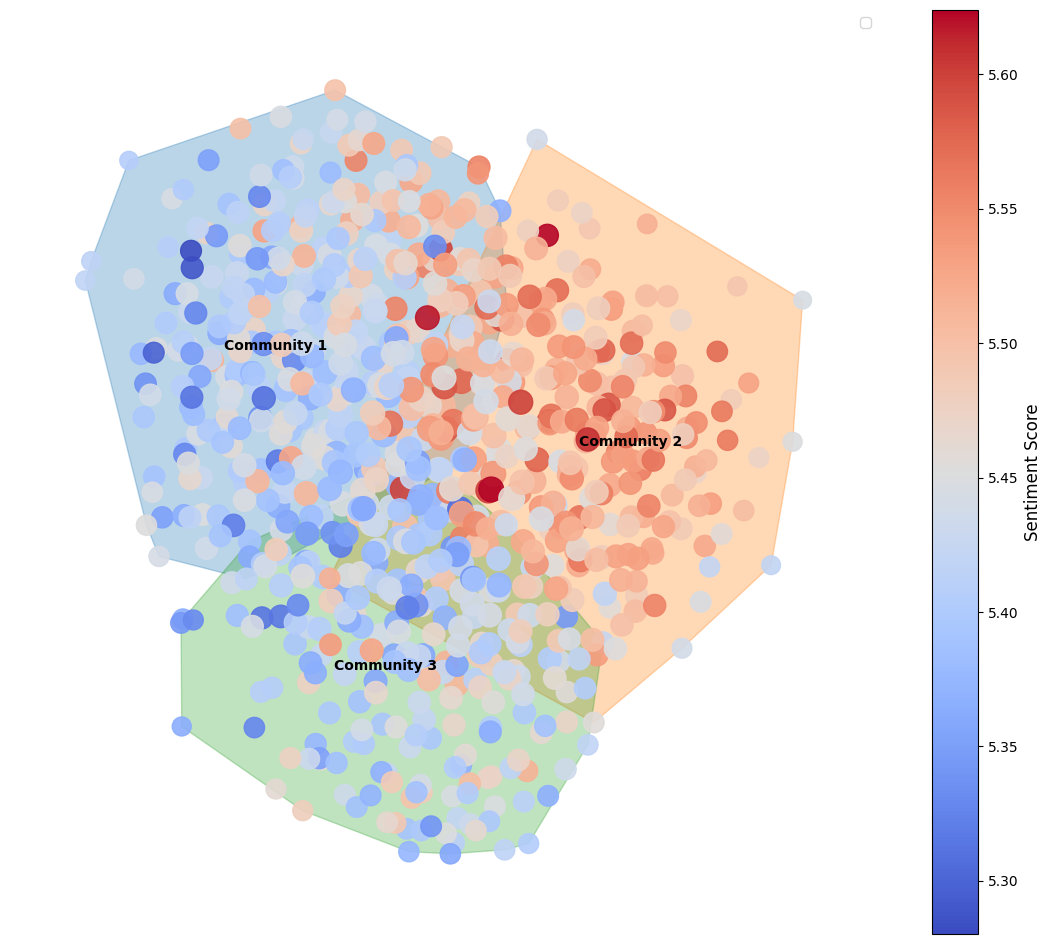

In [8]:
sentiment_scores = {row['movieId']: row['average_sentiment'] for _, row in merged_df.iterrows()}
min_sentiment = min(sentiment_scores.values())
max_sentiment = max(sentiment_scores.values())
normalized_sentiments = {
    node: (sentiment_scores.get(node, 0) - min_sentiment) / (max_sentiment - min_sentiment)
    for node in G_tags.nodes()
}
colormap = plt.cm.coolwarm
node_colors = [colormap(normalized_sentiments[node]) for node in G_tags.nodes()]

centrality = nx.betweenness_centrality(G_tags, normalized=True)

degrees = dict(G_tags.degree())
min_degree = min(degrees.values())
max_degree = max(degrees.values())

node_sizes = [degrees[node] for node in G_tags.nodes()]
node_sizes = [50 + (degrees[node] ** 0.5) * 10 for node in G_tags.nodes()]


pos = nx.spring_layout(G_tags, k=0.15, iterations=100)

fig, ax = plt.subplots(figsize=(14, 12))

colors = list(mcolors.TABLEAU_COLORS.values())
if len(communities) > len(colors):
    colors += list(mcolors.CSS4_COLORS.values())[:len(communities) - len(colors)]

patches = []
for i, community in enumerate(communities):
    community_pos = np.array([pos[node] for node in community if node in pos])
    if len(community_pos) > 2:  
        hull = ConvexHull(community_pos)
        polygon = [community_pos[vertex] for vertex in hull.vertices]
        polygon.append(polygon[0])  
        polygon = np.array(polygon)
        patches.append(Polygon(polygon, closed=True, color=colors[i % len(colors)], alpha=0.3, label=f"Community {i+1}"))

        centroid_x = np.mean(polygon[:, 0])
        centroid_y = np.mean(polygon[:, 1])

        ax.text(
            centroid_x,
            centroid_y,
            f"Community {i+1}",
            fontsize=10,
            fontweight="bold",
            color="black",
            ha="center",
            va="center",
        )

patch_collection = PatchCollection(patches, match_original=True)
ax.add_collection(patch_collection)

nx.draw_networkx_nodes(
    G_tags,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    ax=ax,
)
nx.draw_networkx_edges(
    G_tags,
    pos,
    alpha=0.0015,
    width=[1.5 * G_tags[u][v].get("weight", 1) for u, v in G_tags.edges()],
    edge_color="gray",
    ax=ax,
)

sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min_sentiment, vmax=max_sentiment))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sentiment Score", fontsize=12)


ax.legend(loc='upper right', fontsize=10)
plt.axis("off")  
plt.show()


In [9]:


community_summary = []

for community_idx, movies in enumerate(communities):
    community_movies = merged_df[merged_df['movieId'].isin(movies)]
    
    num_movies = len(community_movies)
    
    tags = []
    for movie in movies:
        tags.extend(movie_top_tags.get(movie, []))
    top_tags = Counter(tags).most_common(10)
    top_tags_str = ", ".join([f"{tag} ({count})" for tag, count in top_tags])
    
    genre_counts = community_movies['genres_y'].str.split('|').explode().value_counts(normalize=True) * 100
    genre_distribution = ", ".join([f"{genre}: {count:.1f}%" for genre, count in genre_counts.items()])
    
    community_summary.append({
        "Community": community_idx + 1,
        "Number of Movies": num_movies,
        "Top Tags": top_tags_str,
        "Genre Distribution": genre_distribution
    })

community_summary_df = pd.DataFrame(community_summary)



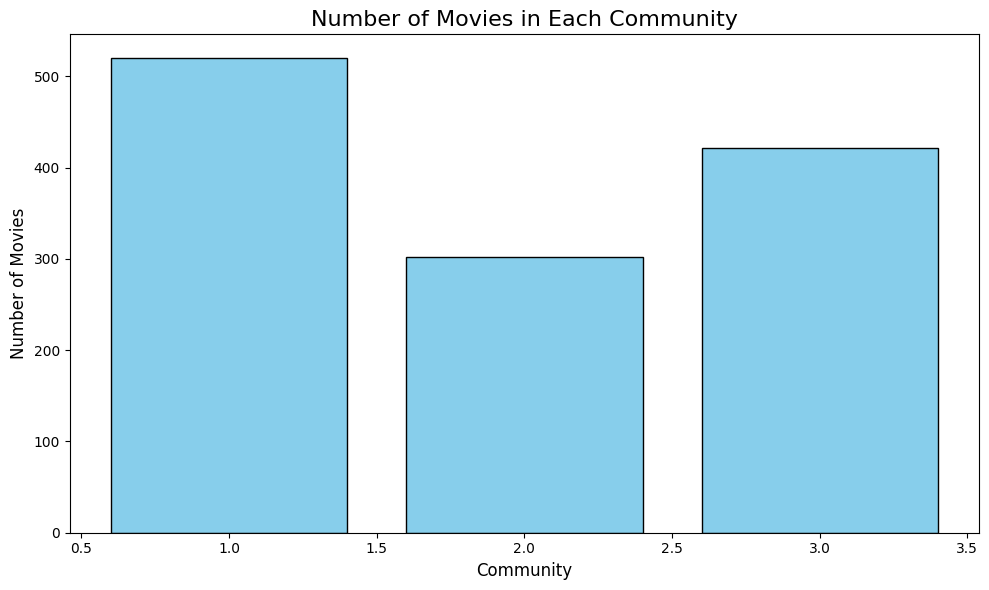

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(
    community_summary_df['Community'],
    community_summary_df['Number of Movies'],
    color='skyblue',
    edgecolor='black'
)
plt.title("Number of Movies in Each Community", fontsize=16)
plt.xlabel("Community", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


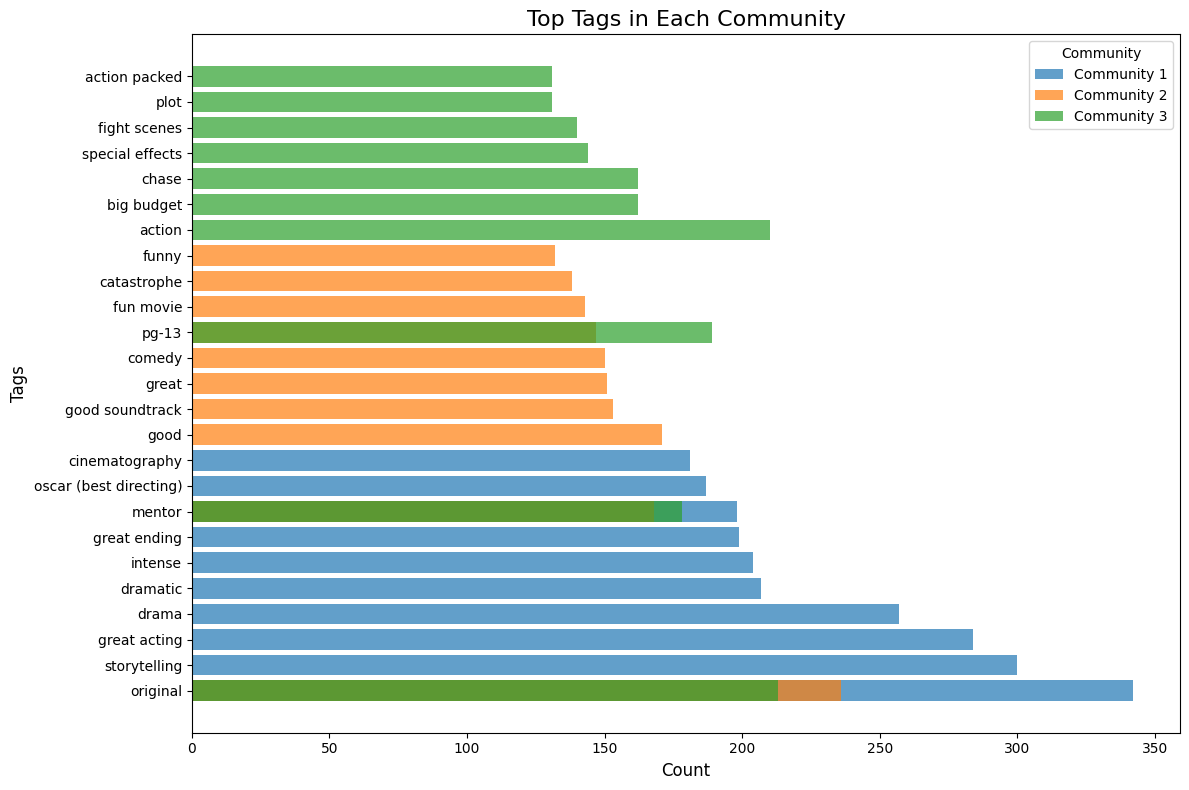

In [11]:

top_tags_data = []
for _, row in community_summary_df.iterrows():
    for tag_info in row['Top Tags'].split(", "):
        tag, count = tag_info.rsplit(" (", 1)  
        count = int(count.strip(")"))  
        top_tags_data.append({
            "Community": row['Community'],
            "Tag": tag,
            "Count": count
        })

top_tags_df = pd.DataFrame(top_tags_data)



top_tags_df = pd.DataFrame(top_tags_data)

plt.figure(figsize=(12, 8))
for community in top_tags_df['Community'].unique():
    subset = top_tags_df[top_tags_df['Community'] == community]
    plt.barh(
        subset['Tag'],
        subset['Count'],
        label=f"Community {community}",
        alpha=0.7
    )

plt.title("Top Tags in Each Community", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Tags", fontsize=12)
plt.legend(title="Community", fontsize=10)
plt.tight_layout()
plt.show()


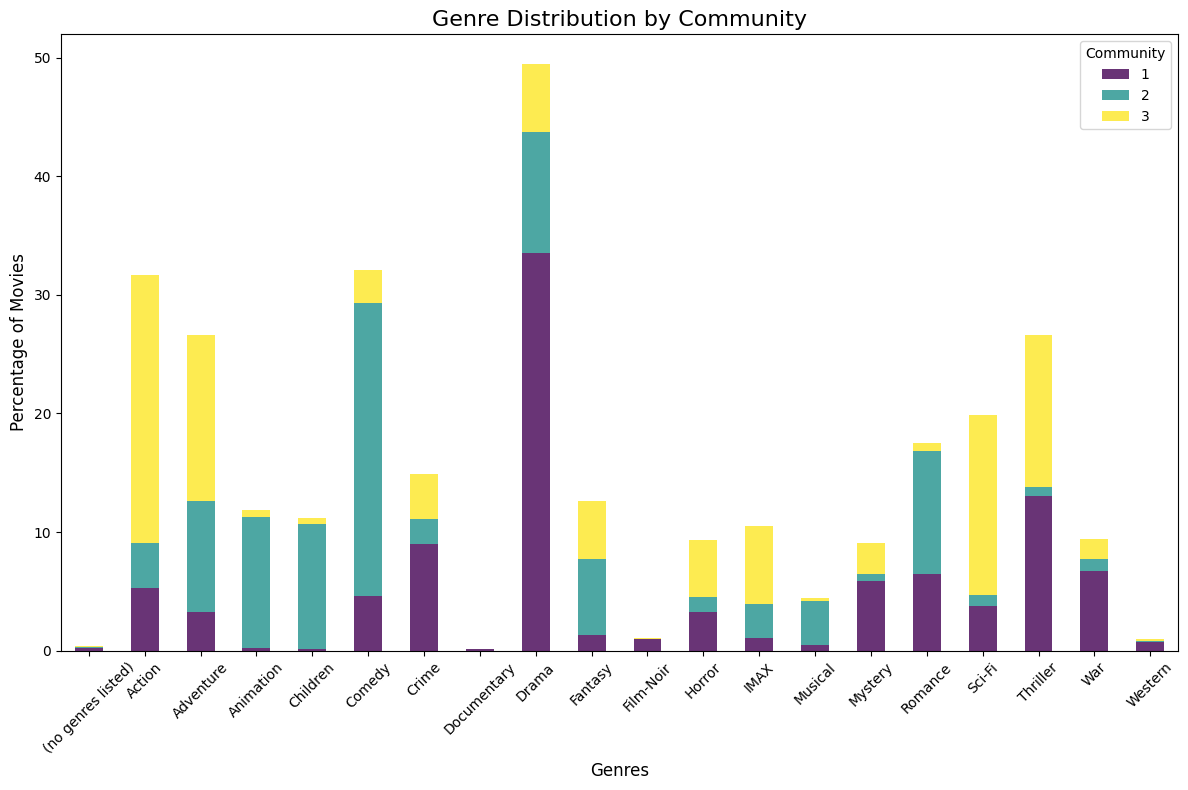

In [12]:
genre_data = []
for _, row in community_summary_df.iterrows():
    for genre_info in row['Genre Distribution'].split(", "):
        genre, percentage = genre_info.split(": ")
        percentage = float(percentage.strip("%"))
        genre_data.append({
            "Community": row['Community'],
            "Genre": genre,
            "Percentage": percentage
        })

genre_df = pd.DataFrame(genre_data)

pivot_genre = genre_df.pivot(index="Genre", columns="Community", values="Percentage").fillna(0)

pivot_genre.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
    colormap="viridis",
    alpha=0.8
)
plt.title("Genre Distribution by Community", fontsize=16)
plt.xlabel("Genres", fontsize=12)
plt.ylabel("Percentage of Movies", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Community", fontsize=10)
plt.tight_layout()
plt.show()


In [13]:
# Adding the communities into the dataframe for further analysis.
community_mapping = {}

for community_id, movie_ids in enumerate(communities, start=1):
    for movie_id in movie_ids:
        community_mapping[movie_id] = int(community_id)

merged_df["Community"] = merged_df["movieId"].map(community_mapping)


# Analyse the genres with the communities

In [14]:


movie_genres = {row['movieId']: row['genres_y'].split('|') for _, row in merged_df.iterrows()}

community_genre_stats = []
for idx, community in enumerate(communities):
    community_genres = []
    for movie in community:
        if movie in movie_genres:
            community_genres.extend(movie_genres[movie])
    
    genre_counts = Counter(community_genres)
    community_genre_stats.append({
        "Community": idx + 1,
        "Size": len(community),
        "Top Genres": genre_counts.most_common(5),  
        "Genre Distribution": genre_counts
    })

genre_df = pd.DataFrame(community_genre_stats)





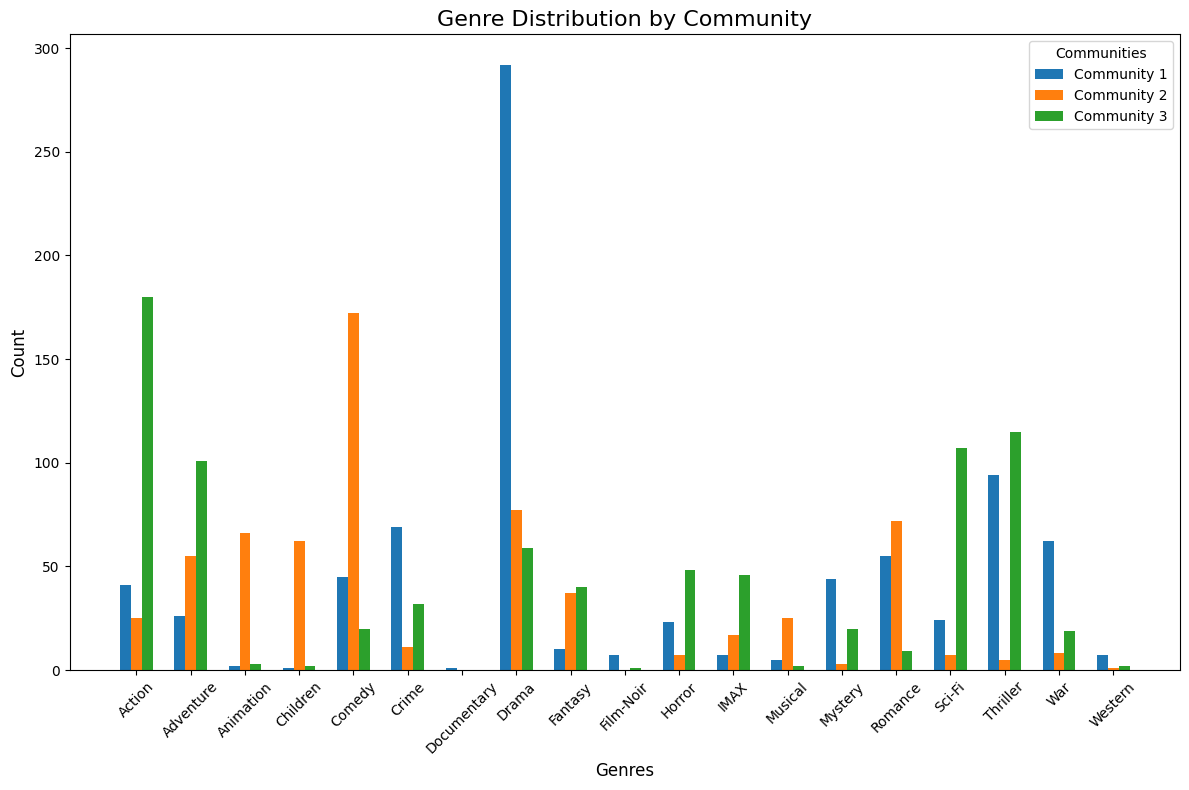

In [15]:
flattened_data = []
for idx, row in genre_df.iterrows():
    community = row['Community']
    genre_distribution = row['Genre Distribution']
    for genre, count in genre_distribution.items():
        if genre != '(no genres listed)':
            flattened_data.append({"Community": community, "Genre": genre, "Count": count})

flattened_df = pd.DataFrame(flattened_data)

pivot_df = flattened_df.pivot(index="Genre", columns="Community", values="Count").fillna(0)

bar_width = 0.2
x = np.arange(len(pivot_df.index))  

plt.figure(figsize=(12, 8))

for idx, community in enumerate(pivot_df.columns):
    plt.bar(
        x + idx * bar_width,  
        pivot_df[community], 
        bar_width, 
        label=f"Community {community}"
    )

plt.title("Genre Distribution by Community", fontsize=16)
plt.xlabel("Genres", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(x + bar_width, pivot_df.index, rotation=45, fontsize=10)  
plt.legend(title="Communities", fontsize=10)
plt.tight_layout()

plt.show()


# Detailed community summaries

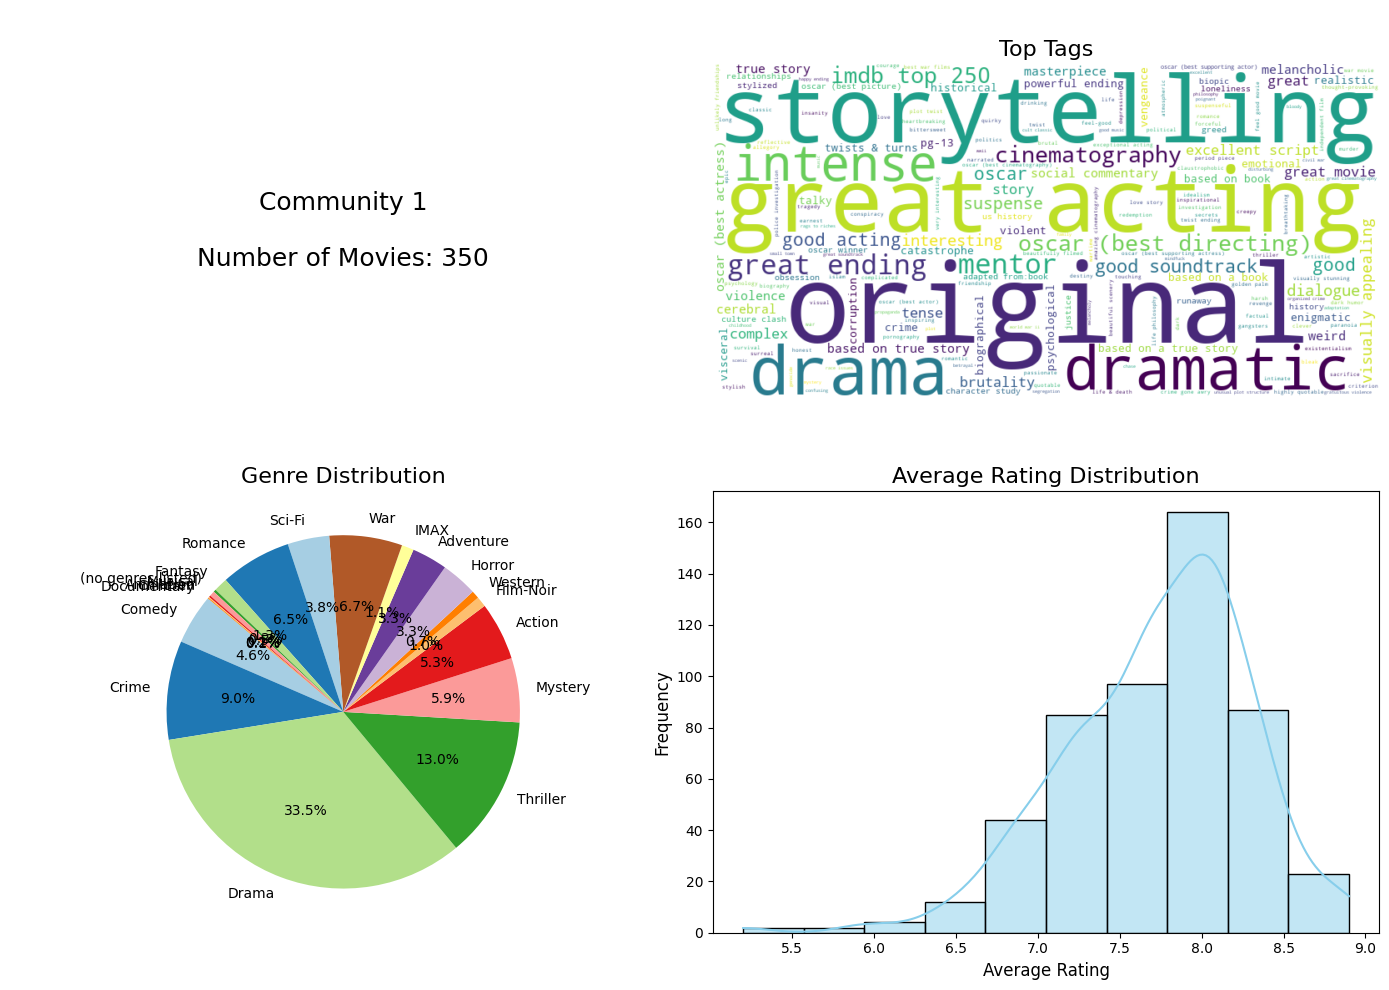

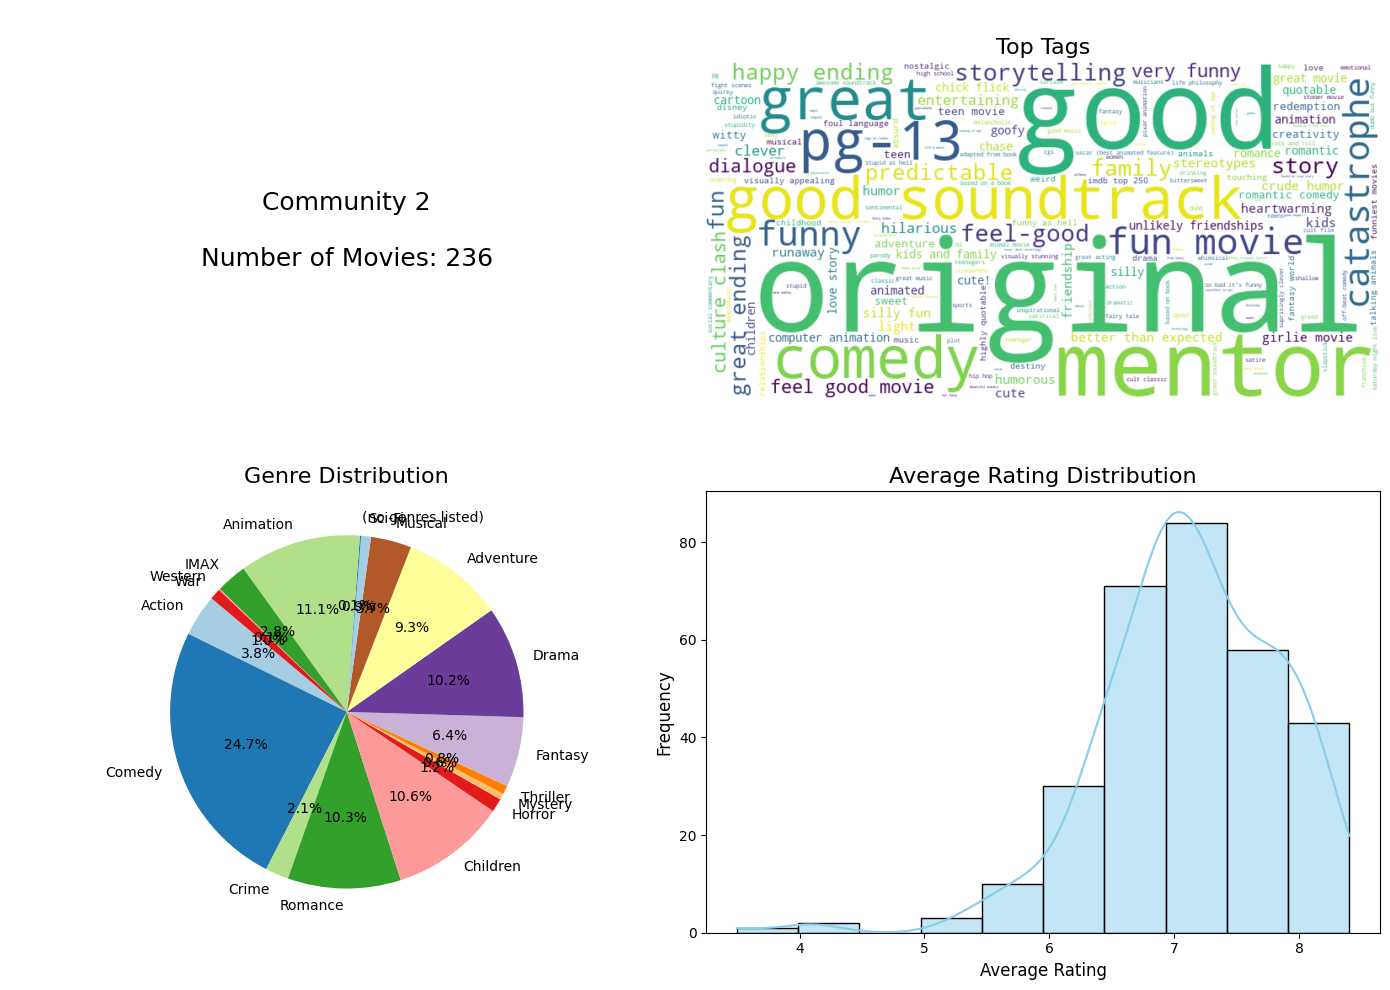

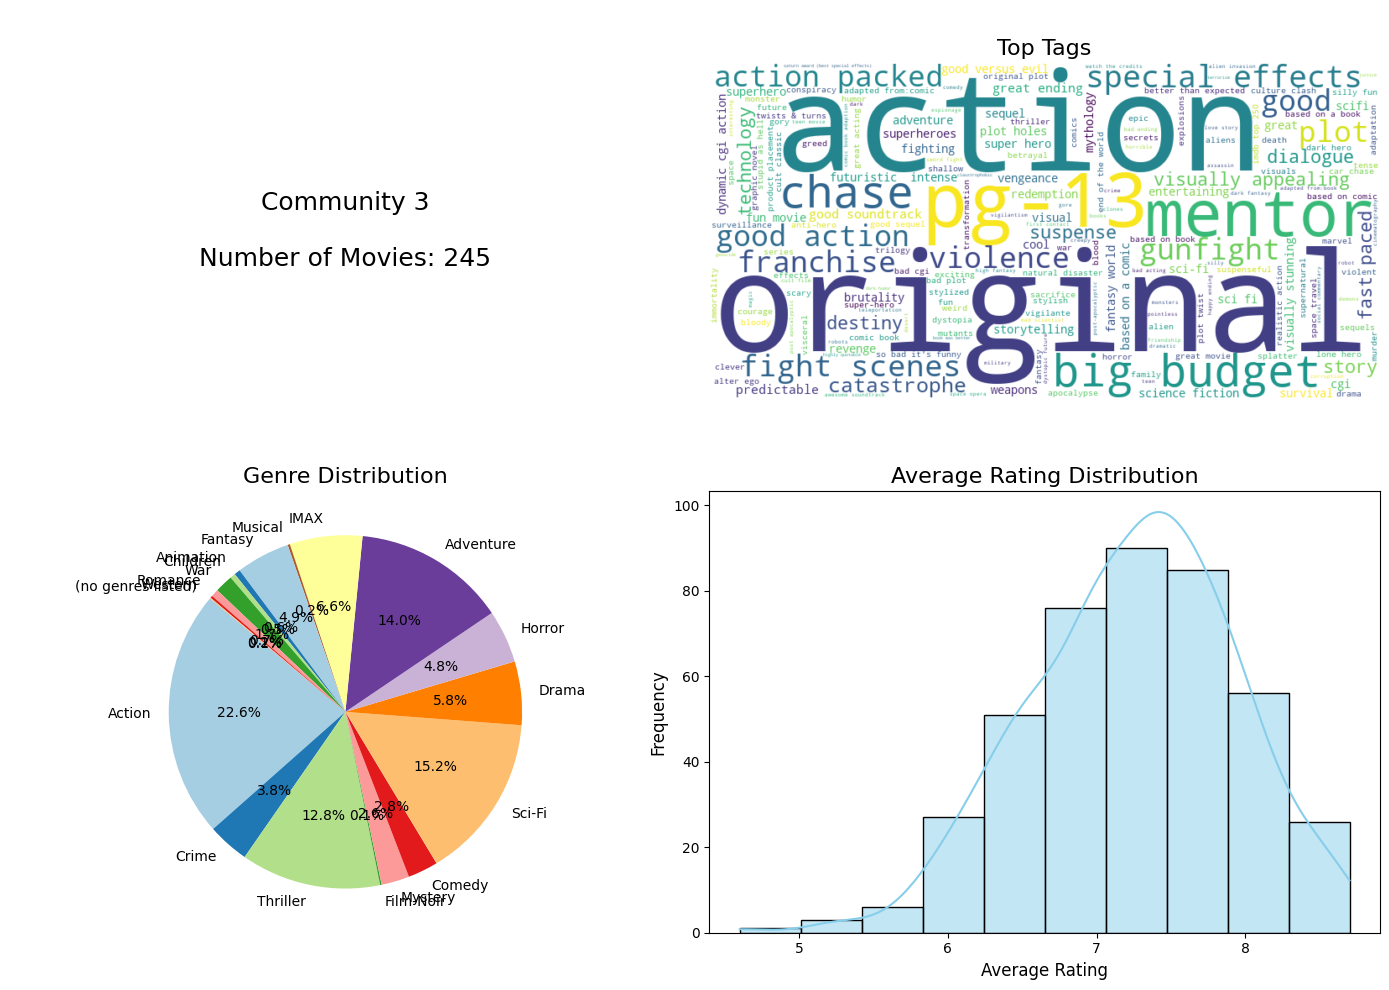

In [16]:


def create_community_summary(community_id, movies, tags, genres, ratings):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.text(0.5, 0.5, 
             f"Community {community_id}\n\nNumber of Movies: {len(movies)}", 
             fontsize=18, ha='center', va='center', wrap=True)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    wc = WordCloud(background_color='white', colormap='viridis', width=800, height=400)
    tag_counts = Counter(tags)
    wc.generate_from_frequencies(tag_counts)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title("Top Tags", fontsize=16)
    
    plt.subplot(2, 2, 3)
    genre_counts = Counter(genres)
    labels = list(genre_counts.keys())
    sizes = list(genre_counts.values())
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title("Genre Distribution", fontsize=16)
    
    plt.subplot(2, 2, 4)
    sns.histplot(ratings, kde=True, bins=10, color='skyblue', edgecolor='black')
    plt.title("Average Rating Distribution", fontsize=16)
    plt.xlabel("Average Rating", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"community_{community_id}_summary.png")
    plt.show()

for community_id, movies in enumerate(communities, start=1):
    community_movies = merged_df[merged_df['movieId'].isin(movies)]
    
    community_tags = []
    for movie in movies:
        community_tags.extend(movie_top_tags.get(movie, []))
    
    community_genres = community_movies['genres_y'].str.split('|').explode().tolist()
    community_ratings = community_movies['rating'].dropna().tolist()
    
    create_community_summary(
        community_id=community_id,
        movies=movies,
        tags=community_tags,
        genres=community_genres,
        ratings=community_ratings
    )


# Analyse Sentiments within communities.

In [22]:
movie_sentiments = {row['movieId']: row['average_sentiment'] for _, row in merged_df.iterrows()}


community_sentiment_stats = []
for idx, community in enumerate(communities):
    community_sentiments = []
    for movie in community:
        if movie in movie_sentiments:
            community_sentiments.append(movie_sentiments[movie])  
    
    sentiment_counts = Counter(community_sentiments)
    community_sentiment_stats.append({
        "Community": idx + 1,
        "Size": len(community),
        "Top Sentiments": sentiment_counts.most_common(5),  
        "Sentiment Distribution": sentiment_counts
    })

sentiment_df = pd.DataFrame(community_sentiment_stats)

print(sentiment_df.head())

   Community  Size                                     Top Sentiments  \
0          1   350  [(5.465592968528391, 1), (5.45543406804541, 1)...   
1          2   236  [(5.592884160038165, 1), (5.580511496282083, 1...   
2          3   245  [(5.365982026245039, 1), (5.446399646001184, 1...   

                              Sentiment Distribution  
0  {5.465592968528391: 1, 5.45543406804541: 1, 5....  
1  {5.592884160038165: 1, 5.580511496282083: 1, 5...  
2  {5.365982026245039: 1, 5.446399646001184: 1, 5...  


# Analyse rating within communities

- Store the community size and average rating in a DataFrame - community_ratings_df
- Identify the top 3 most common genres for each community with their occurrence counts and store the results in a DataFrame - top_genres_df
- Plotting rating distribution for each community both in kde and boxplot

In [17]:

movie_ratings = {row['movieId']: row['rating'] for _, row in merged_df.iterrows()}


community_ratings = []
for idx, community in enumerate(communities):
    community_ratings_list = []
    for movie in community:
        if movie in movie_ratings:
            community_ratings_list.append(movie_ratings[movie])
    
    avg_rating = sum(community_ratings_list) / len(community_ratings_list) if community_ratings_list else 0
    community_ratings.append({
        "Community": idx + 1,
        "Average Rating": avg_rating,
        "Size": len(community_ratings_list)
    })

community_ratings_df = pd.DataFrame(community_ratings)

top_genres_data = []
for idx, community in enumerate(communities):
    community_movies = merged_df[merged_df['movieId'].isin(community)]
    genres = community_movies['genres_y'].str.split('|').explode()
    top_genres = Counter(genres).most_common(3)
    top_genres_data.append({
        "Community": f"Community {idx + 1}",
        "Top Genres": ", ".join([f"{genre} ({count})" for genre, count in top_genres])
    })

top_genres_df = pd.DataFrame(top_genres_data)


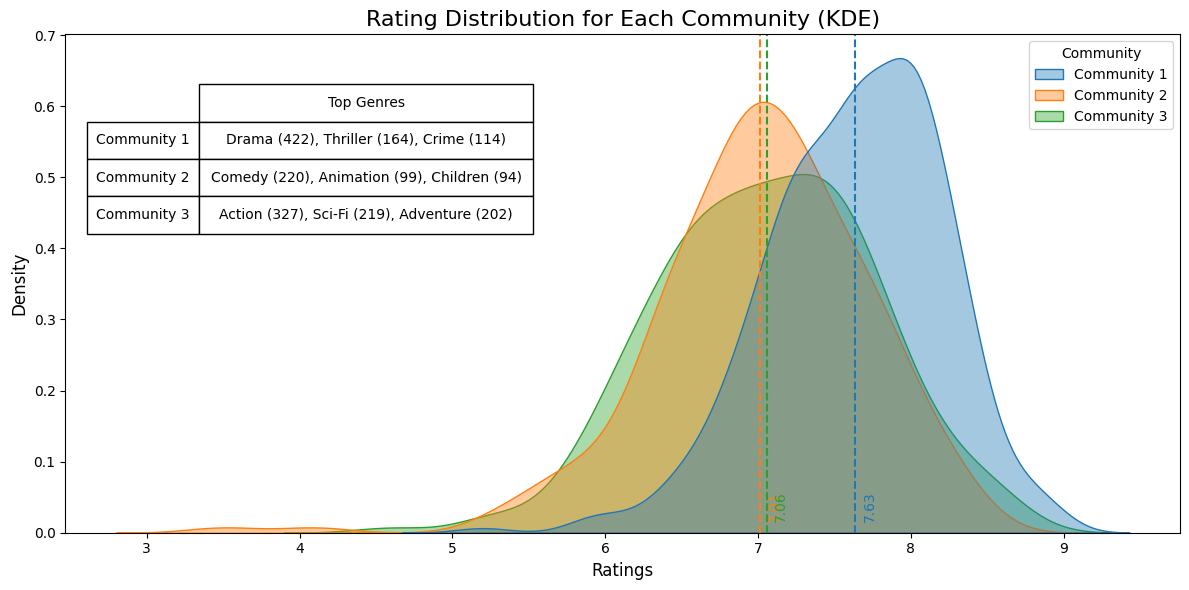

In [18]:

community_ratings_all = []

for idx, community in enumerate(communities):
    for movie in community:
        if movie in movie_ratings:
            community_ratings_all.append({"Community": f"Community {idx + 1}", "Rating": movie_ratings[movie]})

community_ratings_df = pd.DataFrame(community_ratings_all)

plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=community_ratings_df,
    x="Rating",
    hue="Community",
    fill=True,
    common_norm=False,
    alpha=0.4
)
means = community_ratings_df.groupby('Community')['Rating'].mean()
for idx, (community, mean_value) in enumerate(means.items()):
    plt.axvline(mean_value, linestyle='--', color=f"C{idx}", label=f"{community} Mean: {mean_value:.2f}")
    plt.text(mean_value + 0.05, 0.02, f"{mean_value:.2f}", rotation=90, color=f"C{idx}", fontsize=10)


table_data = top_genres_df.set_index("Community")
cell_text = table_data.values
rows = table_data.index
columns = ["Top Genres"]
table = plt.table(
    cellText=cell_text,
    rowLabels=rows,
    colLabels=columns,
    cellLoc='center',
    rowLoc='center',
    loc='upper right',
    bbox=[0.12, 0.6, 0.3, 0.3]  
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)


plt.title("Rating Distribution for Each Community (KDE)", fontsize=16)
plt.xlabel("Ratings", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_5220/3840734472.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(community_ratings_data, labels=community_labels, patch_artist=True)


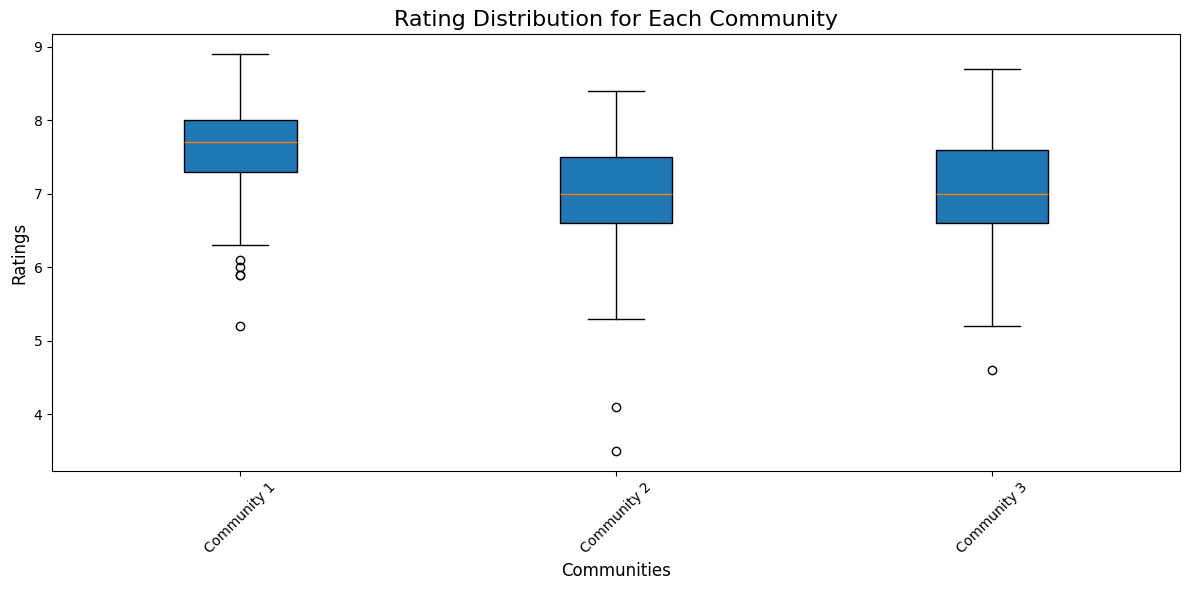

In [19]:
community_ratings_data = []
community_labels = []

for idx, community in enumerate(communities):
    community_ratings_list = []
    for movie in community:
        if movie in movie_ratings:
            community_ratings_list.append(movie_ratings[movie])
    if community_ratings_list:  
        community_ratings_data.append(community_ratings_list)
        community_labels.append(f"Community {idx + 1}")

plt.figure(figsize=(12, 6))
plt.boxplot(community_ratings_data, labels=community_labels, patch_artist=True)
plt.title("Rating Distribution for Each Community", fontsize=16)
plt.xlabel("Communities", fontsize=12)
plt.ylabel("Ratings", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Movie lengths - not used

In [23]:

def convert_to_minutes(runtime_str):
    if isinstance(runtime_str, str):
        hours = 0
        minutes = 0
        hour_match = re.search(r"(\d+)h", runtime_str)
        if hour_match:
            hours = int(hour_match.group(1))
        minute_match = re.search(r"(\d+)min", runtime_str)
        if minute_match:
            minutes = int(minute_match.group(1))
        return hours * 60 + minutes
    return None  

merged_df["run_length_minutes"] = merged_df["run_length"].apply(convert_to_minutes)

print(merged_df[["run_length", "run_length_minutes"]].head())


  run_length  run_length_minutes
0   2h 32min                 152
1   2h 34min                 154
2   2h 26min                 146
3   1h 51min                 111
4   1h 39min                  99


In [26]:
community_info = []

for community, group in merged_df.groupby("Community"):
    num_movies = len(group)
    avg_rating = group["rating"].mean()
    median_rating = group["rating"].median()
    genre_counts = group["genres_x"].str.split(';').explode().value_counts()
    top_genres = ", ".join(genre_counts.index[:3])  # Top 3 genres
    avg_runtime = group["run_length_minutes"].mean()

    community_info.append({
        "Community": community,
        "Number of Movies": num_movies,
        "Average Rating": round(avg_rating, 2),
        "Median Rating": round(median_rating, 2),
        "Top Genres": top_genres,
        "Average Runtime (mins)": round(avg_runtime, 2)
    })

community_info_df = pd.DataFrame(community_info)
print(community_info_df)

   Community  Number of Movies  Average Rating  Median Rating  \
0        1.0               520            7.73            7.8   
1        2.0               302            7.13            7.1   
2        3.0               421            7.24            7.3   

              Top Genres  Average Runtime (mins)  
0        ,  Drama, Drama                  129.68  
1    , Comedy, Animation                  105.01  
2   , Action,  Adventure                  123.14  


# Betweenness centrality - not used

In [27]:
betweenness_centrality = nx.betweenness_centrality(G_tags, normalized=True, weight="weight")

sorted_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Top nodes by betweenness centrality:")
for node, centrality in sorted_centrality[:10]:  
    node = merged_df[merged_df['movieId'] == node]['name'].iloc[0]
    print(f"Node: {node}, Betweenness Centrality: {centrality:.4f}")


Top nodes by betweenness centrality:
Node: Underworld, Betweenness Centrality: 0.0028
Node: It, Betweenness Centrality: 0.0025
Node: Rango, Betweenness Centrality: 0.0024
Node: Sinister, Betweenness Centrality: 0.0023
Node: Orphan, Betweenness Centrality: 0.0023
Node: The Nice Guys, Betweenness Centrality: 0.0021
Node: The Hunger Games: Catching Fire, Betweenness Centrality: 0.0021
Node: Sweeney Todd: The Demon Barber of Fleet Street, Betweenness Centrality: 0.0020
Node: True Romance, Betweenness Centrality: 0.0020
Node: Tropic Thunder, Betweenness Centrality: 0.0020


# Sentiment density for the genres in a kde

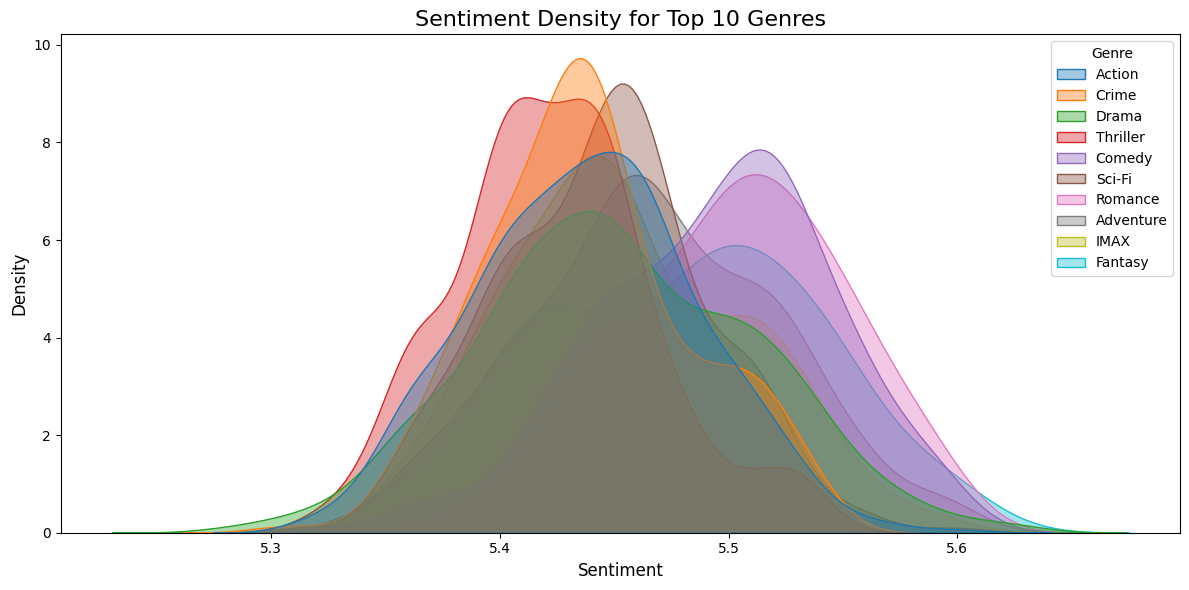

In [20]:
genre_sentiments = []

for _, row in merged_df.iterrows():
    row['genres_y'] = row['genres_y'].split('|')
    if isinstance(row['genres_y'], list): 
        for genre in row['genres_y']:
            genre_sentiments.append({"Genre": genre, "Sentiment": row['average_sentiment']})

genre_sentiments_df = pd.DataFrame(genre_sentiments)

top_genres = genre_sentiments_df['Genre'].value_counts().head(10).index
filtered_genre_sentiments_df = genre_sentiments_df[genre_sentiments_df['Genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=filtered_genre_sentiments_df,
    x="Sentiment",
    hue="Genre",
    fill=True,
    common_norm=False,
    alpha=0.4
)

plt.title("Sentiment Density for Top 10 Genres", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.show()
